##**Clasificación de Riesgo Ambiental y Territorial en Argentina mediante Aprendizaje Automático**

**Alumna:** Velazque Miriam

###**Exploración y Preprocesamiento del Dataset**

##1. Introducción

**Objetivo**: construir un conjunto de datos listo para modelado supervisado, orientado a predecir zonas afectadas por inundaciones.
A partir de la integración de múltiples fuentes geoespaciales, se realiza un proceso detallado de limpieza, codificación, reproyección, cálculo de centroides y generación de variables predictoras.  
El enfoque combina técnicas de análisis espacial con criterios ambientales y sociales, incorporando variables como la frecuencia de inundación, la distancia a cuerpos y cursos de agua, y la presencia de microbasurales cercanos.  
Cada paso se documenta y justifica, con visualizaciones y verificaciones técnicas que aseguran la calidad del dataset final.  
Este trabajo sienta las bases para aplicar algoritmos de clasificación en la siguiente etapa del proyecto (Entrega 3), con el fin de aportar valor desde el análisis ambiental y social.



##2. Preparación del entorno Carga de Datasets

In [2]:
# Carga manual de archivos
from google.colab import files
uploaded = files.upload()


Saving du_techo_cuerpos_de_agua.geojson to du_techo_cuerpos_de_agua.geojson
Saving du_techo_cursos_de_agua.geojson to du_techo_cursos_de_agua.geojson
Saving du_techo_microbasurales.geojson to du_techo_microbasurales.geojson
Saving du_techo_zonas_inundables.csv to du_techo_zonas_inundables.csv


In [19]:
# Preparamos el entorno
import pandas as pd
import geopandas as gpd

# Cargar los datasets
zonas_inundables = pd.read_csv("du_techo_zonas_inundables.csv")
cuerpos_agua = gpd.read_file("du_techo_cuerpos_de_agua.geojson")
cursos_agua = gpd.read_file("du_techo_cursos_de_agua.geojson")
microbasurales = gpd.read_file("du_techo_microbasurales.geojson")

En esta sección se cargan los cuatro datasets que componen la base de datos del proyecto.

`du_techo_zonas_inundables.csv` contiene información tabular sobre zonas afectadas por inundaciones, incluyendo la variable objetivo se_inunda_.

`du_techo_cuerpos_de_agua.geojson`, `du_techo_cursos_de_agua.geojson` y `du_techo_microbasurales.geojson` son capas geoespaciales en formato GeoJSON que representan elementos ambientales relevantes. Se utilizan pandas para el archivo CSV y geopandas para los archivos GeoJSON.

Todos los archivos fueron obtenidos de fuentes públicas: DU-Techo y RENABAP (01//10/2025), y se subieron manualmente a Colab para su procesamiento.
Dataset (fuente)

https://www.datos.gob.ar/dataset/habitat-factores-riesgo-barrios-populares-gran-buenos-aires



##3. Exploración Inicial y Codificación de la Variable Objetivo

Vamos a analizar como está estructurado el dataset principal (du_techo_zonas_inundables.csv) y preparar la variable se_inunda_ para el modelo.

In [20]:
# Exploramos la estructura del dataset
zonas_inundables.info() # vemos estructura general
zonas_inundables.head() # vemos primeras filas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WKT         2746 non-null   object 
 1   id          2746 non-null   int64  
 2   id_poligon  2741 non-null   float64
 3   se_inunda_  2746 non-null   object 
 4   con_que_fr  2746 non-null   object 
 5   provinicia  2746 non-null   object 
 6   departamen  2746 non-null   object 
 7   localidad   2746 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 171.8+ KB


,WKT,id,id_poligon,se_inunda_,con_que_fr,provinicia,departamen,localidad
0,MULTIPOLYGON (((-58.2143471291028 -26.21995308...,1,17325.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Formosa
1,MULTIPOLYGON (((-58.2179226698168 -26.20925840...,2,17322.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES POR AÑO),Formosa,Formosa,Formosa
2,MULTIPOLYGON (((-58.2334597447517 -26.20322391...,3,18578.0,"SÍ, TODO EL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Formosa
3,MULTIPOLYGON (((-58.2764032110572 -26.27741542...,4,12001.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Villa del Carmen
4,MULTIPOLYGON (((-58.2777912542224 -26.27851061...,5,12000.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Villa del Carmen


In [21]:
# Vemos distribución de la variable objetivo
# (incluyendo si hay celdas con valores nulos)
zonas_inundables['se_inunda_'].value_counts(dropna=False)

,count
se_inunda_,
"SÍ, TODO EL BARRIO",1374
"SÍ, SÓLO EN UN SECTOR DEL BARRIO",1372


<Axes: xlabel='se_inunda_'>

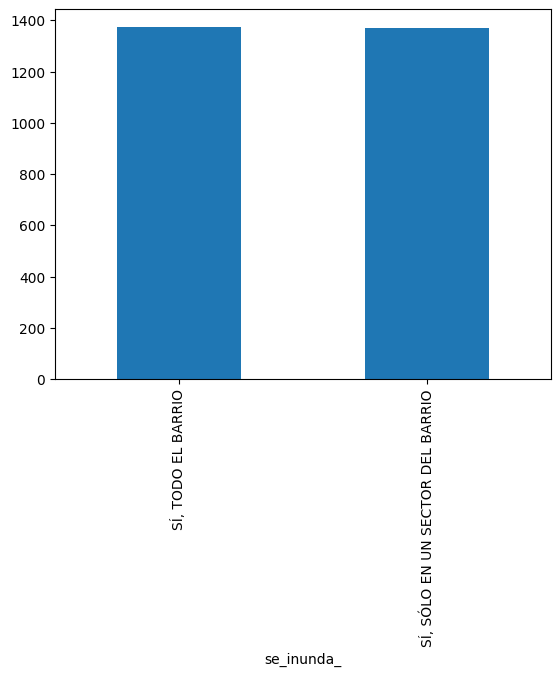

In [22]:
# Visualizamos graficamente la distribucion de la variable objetivo
zonas_inundables['se_inunda_'].value_counts(dropna=False).plot(kind='bar')


Se utiliza value_counts(dropna=False) para contar todas las categorías presentes en la variable `se_inunda_`, incluyendo los valores faltantes (NaN). Esto permite detectar si hay registros incompletos que podrían afectar el modelado o requerir imputación o descarte.

In [23]:
# Inspeccionamos el nombre de todas las columnas del dataset
zonas_inundables.columns


Index(['WKT', 'id', 'id_poligon', 'se_inunda_', 'con_que_fr', 'provinicia',
       'departamen', 'localidad'],
      dtype='object')

Se inspeccionan las columnas del dataset zonas_inundables para identificar las variables disponibles.

Las columnas incluyen:

identificadores (id, id poligon),

información geográfica (provincia, departamen, localidad), y

variables relacionadas con el riesgo de inundación (se_inunda_, con_que_fr).

la columna WKT, contiene geometrías en formato texto

In [24]:
# Exploramos los valores únicos de las columnas categóricas
# Imprime los valores únicos
for col in zonas_inundables.columns:
    if zonas_inundables[col].dtype == 'object':
        print(f"\nValores únicos en {col}:")
        print(zonas_inundables[col].unique())



Valores únicos en WKT:
['MULTIPOLYGON (((-58.2143471291028 -26.2199530868835,-58.2132678708971 -26.2189249124508,-58.2124189527699 -26.2184193481019,-58.21191 -26.218202,-58.210982 -26.218694,-58.2117790166929 -26.2186614916535,-58.212575 -26.219125,-58.2135402582056 -26.2201280771377,-58.2143471291028 -26.2199530868835)))'
 'MULTIPOLYGON (((-58.2179226698168 -26.2092584003946,-58.2200152561458 -26.2037898846083,-58.2194674176553 -26.2038326865085,-58.218947810129 -26.2037211901894,-58.218888 -26.204343,-58.2183626077814 -26.2053971437224,-58.218106 -26.205912,-58.2184509925514 -26.2076616878627,-58.217725 -26.209195,-58.2179226698168 -26.2092584003946)))'
 'MULTIPOLYGON (((-58.2334597447517 -26.2032239116216,-58.2330780486096 -26.2041470664554,-58.234624085 -26.204715812,-58.2355109229999 -26.204996287,-58.2355719719999 -26.2048782,-58.2357920768874 -26.2043956307624,-58.2355450237146 -26.2043008661955,-58.2357106933368 -26.2039012425633,-58.2350769559999 -26.2037040049003,-58.234516

##**Interpretación de la exploración inicial**

##Variable se_inunda_
Valores únicos encontrados:

"SÍ, TODO EL BARRIO" (1374 registros)

"SÍ, SÓLO EN UN SECTOR DEL BARRIO" (1372 registros)

No se detectaron registros con la categoría "NO SE INUNDA", lo cual indica que el dataset está compuesto exclusivamente por zonas que presentan algún nivel de inundación.
Es por ello que tomamos la decisión de trabajar con una clasificación binaria supervisada, diferenciando entre inundación total (2) e inundación parcial (1).

##Variable con_que_fr
Valores únicos encontrados:

"CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES POR AÑO)" (1488)

"OCASIONALMENTE (ALGUNAS VECES POR AÑO)" (638)

"SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR AÑO)" (572)

"Otro, especificar" (43)

"NS/NC" (2)

Otros valores con muy baja frecuencia (1–2 registros)

Esta variable aporta información sobre la frecuencia de inundación, lo cual puede ser útil como variable predictora. Se observa una predominancia de zonas que se inundan con frecuencia alta. Podríamos agrupar en categorías (Alta, Media, Baja) para facilitar el modelado.

##Variable provincia, departamento y localidad

Valores únicos encontrados: Más de 20 provincias. Más de 50 departamentos. Más de 100 localidades.
 En los 3 casos, aunque las variables aportan contexto geográfico, se decide no incluirlas como variable predictora debido a que:

Tienen muchas categorías.

La ubicación ya está representada por coordenadas (latitud, longitud).

Podría introducir ruido en el modelo y sobreajuste.

##Variable WKT

Valores únicos: Geometrías en formato MULTIPOLYGON

Esta columna contiene la geometría de cada zona en formato texto. No se usará directamente en el modelo, pero se puede utilizar para calcular variables derivadas como el centroide o el área.

In [25]:
# Vemos la distribución de la variable con_que_fr
zonas_inundables['con_que_fr'].value_counts(dropna=False)

,count
con_que_fr,
CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES POR AÑO),1488
OCASIONALMENTE (ALGUNAS VECES POR AÑO),638
SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR AÑO),572
"Otro, especificar",43
NS/NC,2
CADA VEZ QUE LLUEVE (MUCHAS VECES POR AÑO),2
CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES AL AÑO),1


<Axes: xlabel='con_que_fr'>

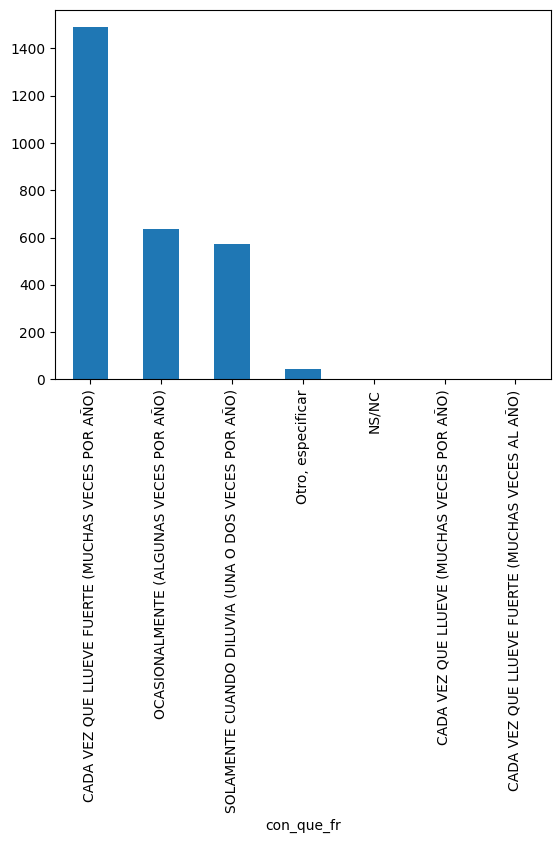

In [26]:
# Visualizamos graficamente la distribución de la variable con_que_fr
zonas_inundables['con_que_fr'].value_counts(dropna=False).plot(kind='bar')


##Interpretación

La mayoría de las zonas se inundan frecuentemente: más de la mitad (1488 de 2746) reportan que se inundan cada vez que llueve fuerte.

Hay una proporción significativa que se inunda ocasionalmente (638) o solo en eventos extremos (572).

Los valores "Otro, especificar" y "NS/NC" son pocos, pero podrían representar respuestas abiertas o falta de información.

Aparecen duplicados con pequeñas variaciones en la redacción, como "CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES POR AÑO)" y "CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES AL AÑO)", vamos a normalizar estos textos.

In [28]:
# Preprocesamiento (agrupamos en tres categorías simplificadas)
# Transformación de variable categórica textual (con_que_fr) en una versión más simplificada y estructurada
def codificar_frecuencia(valor):
    valor = str(valor).upper()
    if "CADA VEZ" in valor or "MUCHAS VECES" in valor:
        return "Alta"
    elif "OCASIONALMENTE" in valor:
        return "Media"
    elif "SOLAMENTE" in valor or "UNA O DOS VECES" in valor:
        return "Baja"
    else:
        return "Otro"

zonas_inundables['frecuencia_codificada'] = zonas_inundables['con_que_fr'].apply(codificar_frecuencia)

zonas_inundables['frecuencia_codificada'].value_counts(dropna=False)

,count
frecuencia_codificada,
Alta,1491
Media,638
Baja,572
Otro,45


/tmp/ipython-input-4234870934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='frecuencia_codificada', data=zonas_gdf, palette='Set2')


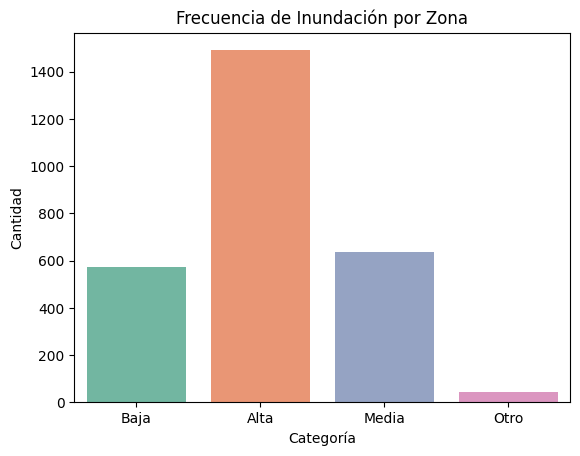

In [52]:
# Distribución de frecuencia_codificada
sns.countplot(x='frecuencia_codificada', data=zonas_gdf, palette='Set2')
plt.title("Frecuencia de Inundación por Zona")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()


Se agrupan los valores en cuatro categorías:

Alta: zonas que se inundan cada vez que llueve fuerte o muchas veces por año.

Media: zonas que se inundan ocasionalmente.

Baja: zonas que solo se inundan en eventos extremos.

Otro: respuestas abiertas o no clasificables.

Esta transformación permite reducir la variabilidad textual y facilita el uso de la variable como predictora en el modelo supervisado.

##**Resultados de la exploración:**
Tras analizar las columnas `se_inunda_` y `con_que_fr`, se observa que el dataset no contiene registros con la categoría "NO SE INUNDA". Esto indica que el archivo `du_techo_zonas_inundables.csv` está compuesto exclusivamente por zonas afectadas por inundaciones, ya sea total o parcialmente. Por lo tanto, se ajusta la variable objetivo a una clasificación binaria:

1: Inundación parcial

2: Inundación total

Esta decisión permite construir un modelo supervisado que prediga el grado de afectación en zonas vulnerables, cumpliendo con el objetivo del proyecto.

Además, se analiza la variable `con_que_fr`, que describe la frecuencia con la que se inunda cada zona. Para facilitar su uso como variable predictora, se realiza un preprocesamiento que agrupa sus valores textuales en cuatro categorías simplificadas:

Alta: Zonas que se inundan cada vez que llueve fuerte o muchas veces por año

Media: Zonas que se inundan ocasionalmente

Baja: Zonas que solo se inundan en eventos extremos

Otro: Respuestas abiertas o no clasificables

Esta nueva variable, frecuencia_codificada, se conservará como predictora en el modelo, ya que aporta información complementaria al tipo de inundación.

##4. Construcción de Variables Predictoras Geoespaciales

Incorporamos variables espaciales que puedan influir en el riesgo de inundación, como la proximidad a cuerpos de agua y a cursos de agua (distancias) o la presencia de microbasurales (cantidad). Estas variables se extraen a partir de las capas geoespaciales disponibles en formato GeoJSON.

**Justificación del uso de geopandas y shapely**
Para enriquecer el dataset con variables ambientales, se utilizan capas geoespaciales que contienen información sobre cuerpos de agua, cursos de agua y microbasurales. Estas capas están en formato GeoJSON, lo que permite trabajar con geometrías mediante la librería geopandas, que extiende pandas para datos espaciales. Además, se utiliza shapely, una librería especializada en operaciones geométricas, como el cálculo de distancias entre polígonos y puntos. El uso de estas herramientas está justificado por la necesidad de generar variables predictoras basadas en la ubicación y el entorno físico de cada zona.

In [31]:
# Convertimos zonas_inundables en un GeoDataFrame
import geopandas as gpd
from shapely import wkt

# Convertimos la columna WKT en geometrías
zonas_inundables['geometry'] = zonas_inundables['WKT'].apply(wkt.loads)

# Creamos el GeoDataFrame
zonas_gdf = gpd.GeoDataFrame(zonas_inundables, geometry='geometry')


wkt.loads convierte el texto WKT en un objeto geométrico de shapely.

geometry='geometry' le indica a geopandas cuál es la columna que contiene las geometrías.

In [ ]:
# Verificamos que se creó correctamente
zonas_gdf.head()



,WKT,id,id_poligon,se_inunda_,con_que_fr,provinicia,departamen,localidad,frecuencia_codificada,geometry
0,MULTIPOLYGON (((-58.2143471291028 -26.21995308...,1,17325.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Formosa,Baja,"MULTIPOLYGON (((-58.21435 -26.21995, -58.21327..."
1,MULTIPOLYGON (((-58.2179226698168 -26.20925840...,2,17322.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",CADA VEZ QUE LLUEVE FUERTE (MUCHAS VECES POR AÑO),Formosa,Formosa,Formosa,Alta,"MULTIPOLYGON (((-58.21792 -26.20926, -58.22002..."
2,MULTIPOLYGON (((-58.2334597447517 -26.20322391...,3,18578.0,"SÍ, TODO EL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Formosa,Baja,"MULTIPOLYGON (((-58.23346 -26.20322, -58.23308..."
3,MULTIPOLYGON (((-58.2764032110572 -26.27741542...,4,12001.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Villa del Carmen,Baja,"MULTIPOLYGON (((-58.2764 -26.27742, -58.27555 ..."
4,MULTIPOLYGON (((-58.2777912542224 -26.27851061...,5,12000.0,"SÍ, SÓLO EN UN SECTOR DEL BARRIO",SOLAMENTE CUANDO DILUVIA (UNA O DOS VECES POR ...,Formosa,Formosa,Villa del Carmen,Baja,"MULTIPOLYGON (((-58.27779 -26.27851, -58.27715..."


La columna geometry fue generada a partir de la columna WKT, utilizando la función wkt.loads para convertir el texto en objetos geométricos tipo MultiPolygon.

Esta transformación permite aplicar operaciones espaciales como cálculo de centroides, distancias y relaciones topológicas, necesarias para construir variables predictoras basadas en el entorno físico de cada zona.

**Calculamos centroides de cada polígono**

Necesitamos obtener un punto representativo de cada zona (su centroide) para poder calcular distancias espaciales de forma precisa.

Calculamos el centroide de cada polígono utilizando el método .centroid de geopandas. El centroide representa el punto medio de cada zona afectada por inundaciones, y se utilizará como referencia para calcular distancias a elementos ambientales cercanos, como cuerpos de agua y microbasurales. Esta operación es posible gracias a la conversión previa del dataset en un GeoDataFrame, que permite aplicar funciones geométricas sobre los objetos espaciales.

###Reproyección y cálculo de centroides

Para calcular correctamente los centroides de cada polígono en unidades métricas, se reproyecta el GeoDataFrame al sistema de coordenadas proyectado **EPSG:5347 (POSGAR 2007 / Argentina 3)**, que cubre todo el territorio nacional.  
Luego se calcula el centroide de cada geometría, lo cual permite generar variables espaciales como distancia a cuerpos de agua o microbasurales.


In [34]:
# Definimos CRS original si no estaba definido
zonas_gdf = zonas_gdf.set_crs(epsg=4326)

# Reproyectamos a sistema en metros (EPSG:5347)
zonas_gdf = zonas_gdf.to_crs(epsg=5347)

# Calculamos centroides
zonas_gdf['centroide'] = zonas_gdf.geometry.centroid

# Verificamos  los resultados
zonas_gdf[['geometry', 'centroide']].head()


,geometry,centroide
0,"MULTIPOLYGON (((5678459.101 7099534.297, 56785...",POINT (5678606.905 7099622.752)
1,"MULTIPOLYGON (((5678117.978 7100724.445, 56779...",POINT (5678028.389 7101126.919)
2,"MULTIPOLYGON (((5676573.859 7101414.459, 56766...",POINT (5676471.255 7101319.784)
3,"MULTIPOLYGON (((5672171.267 7093250.13, 567225...",POINT (5672170.481 7093118.504)
4,"MULTIPOLYGON (((5672030.974 7093130.605, 56720...",POINT (5672029.439 7093033.059)


Este bloque nos asegura que:

El CRS original está bien definido (EPSG:4326)

La reproyección se aplica correctamente

Los centroides se calculan en metros y son válidos

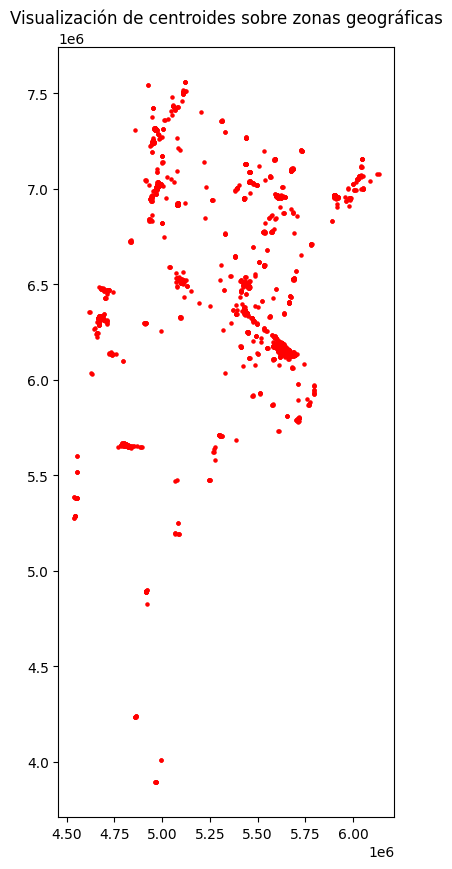

In [35]:
# Visualización de centroides sobre polígonos
import matplotlib.pyplot as plt

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujamos los polígonos (zonas)
zonas_gdf.plot(ax=ax, edgecolor='gray', facecolor='none')

# Dibujamos los centroides en rojo
zonas_gdf.set_geometry('centroide').plot(ax=ax, color='red', markersize=5)

# Título del gráfico
plt.title("Visualización de centroides sobre zonas geográficas")
plt.show()


##Con este gráfico validamos:

Que los centroides estén dentro de cada polígono

Que la reproyección a metros fue exitosa

Que no hay geometrías vacías ni errores de cálculo

Esta transformación es necesaria para obtener centroides y distancias precisas. Una vez reproyectado, se recalculan los centroides de cada polígono, que serán utilizados como referencia para construir variables predictoras basadas en distancia.

Se visualizan los primeros valores de la columna centroide, que contiene los puntos centrales de cada polígono de zona inundable.

Cada entrada es un objeto POINT con coordenadas en metros, que se utilizará como referencia para calcular distancias a elementos ambientales cercanos, como cuerpos de agua y microbasurales.

**Calcular distancia al cuerpo de agua más cercano**

Crear una nueva variable predictora que indique qué tan cerca está cada zona de un cuerpo de agua, lo cual puede influir en el riesgo de inundación.
Verificamos que la capa cuerpos_agua esté en el mismo sistema de coordenadas que zonas_gdf. sino, reproyectamos.

In [40]:
# Reproyectamos cuerpos de agua al mismo CRS que zonas_gdf
cuerpos_agua = cuerpos_agua.to_crs(zonas_gdf.crs)

# Calculamos distancia mínima desde cada centroide
zonas_gdf['distancia_cuerpo_agua'] = zonas_gdf['centroide'].apply(
    lambda punto: cuerpos_agua.distance(punto).min()
)

# Verificamos resultados
zonas_gdf[['centroide', 'distancia_cuerpo_agua']].head()


,centroide,distancia_cuerpo_agua
0,POINT (5678606.905 7099622.752),1197.382158
1,POINT (5678028.389 7101126.919),261.021717
2,POINT (5676471.255 7101319.784),1762.778477
3,POINT (5672170.481 7093118.504),945.972415
4,POINT (5672029.439 7093033.059),1108.288575


### Interpretación del cálculo de distancia a cuerpos de agua

Calculamos la distancia mínima entre el centroide de cada zona inundable y el cuerpo de agua más cercano.  
Primero se reproyecta la capa `cuerpos_agua` al mismo sistema de coordenadas que `zonas_gdf` (EPSG:5347), lo que garantiza que las distancias se midan correctamente en metros.  
Luego, se aplica una función que recorre cada centroide y calcula su distancia más corta a cualquier geometría de la capa de cuerpos de agua.  
El resultado se guarda en una nueva columna llamada `distancia_cuerpo_agua`, que se incorpora como variable predictora en el modelo supervisado.  
Esta variable permite evaluar si la proximidad a cuerpos de agua influye en el riesgo de inundación de cada zona.


/tmp/ipython-input-2941323263.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='se_inunda_binaria', y='distancia_cuerpo_agua', data=zonas_gdf, palette='pastel')


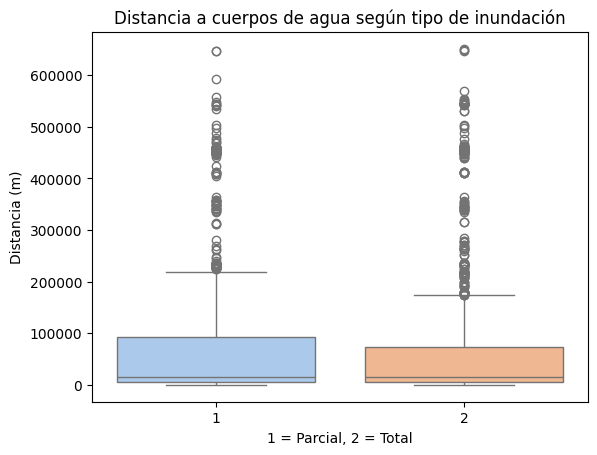

In [53]:
# Visualizamos con un Boxplot la distancia a cuerpos de agua vs tipo de inundación
sns.boxplot(x='se_inunda_binaria', y='distancia_cuerpo_agua', data=zonas_gdf, palette='pastel')
plt.title("Distancia a cuerpos de agua según tipo de inundación")
plt.xlabel("1 = Parcial, 2 = Total")
plt.ylabel("Distancia (m)")
plt.show()


**La variable distancia_cuerpo_agua parece tener poder predictivo: cuanto más cerca está una zona de un cuerpo de agua, mayor es la probabilidad de que se inunde completamente.**

Las zonas con inundación total (2) tienden a estar más cerca de cuerpos de agua que las zonas con inundación parcial (1).

El boxplot de tipo 2 tiene una mediana más baja, lo que indica que la mayoría de esas zonas están a menor distancia.

Hay más dispersión en el grupo 1 (inundación parcial), con varios outliers que están muy lejos de cuerpos de agua.

Esto sugiere que la proximidad a cuerpos de agua podría ser un factor relevante para predecir el grado de inundación.

**Calcular distancia al curso de agua más cercano**

Crear una nueva variable predictora que indique la distancia entre cada zona inundable y el curso de agua más cercano (ríos, arroyos, canales), que también puede influir en el riesgo de inundación.

In [45]:
# Reproyectamos cursos de agua al mismo CRS que zonas_gdf
cursos_agua = cursos_agua.to_crs(zonas_gdf.crs)

# Calculamos distancia mínima desde cada centroide
zonas_gdf['distancia_curso_agua'] = zonas_gdf['centroide'].apply(
    lambda punto: cursos_agua.distance(punto).min()
)
# Verificamos resultados
zonas_gdf[['centroide', 'distancia_curso_agua']].head()

,centroide,distancia_curso_agua
0,POINT (5678606.905 7099622.752),222.458286
1,POINT (5678028.389 7101126.919),62.385068
2,POINT (5676471.255 7101319.784),988.503585
3,POINT (5672170.481 7093118.504),1460.188798
4,POINT (5672029.439 7093033.059),1622.064382


Calculamos la distancia mínima entre el centroide de cada zona inundable y el curso de agua más cercano (ríos, arroyos, canales).  
Primero se reproyecta la capa `cursos_agua` al mismo sistema de coordenadas que `zonas_gdf` (EPSG:5347), lo que garantiza que las distancias se midan correctamente en metros.  
Luego, se aplica una función que recorre cada centroide y calcula su distancia más corta a cualquier geometría de la capa de cursos de agua.  
El resultado se guarda en la columna `distancia_curso_agua`, que se incorpora como variable predictora en el modelo supervisado.  
Esta variable permite evaluar si la cercanía a cursos de agua está asociada a un mayor riesgo de inundación.


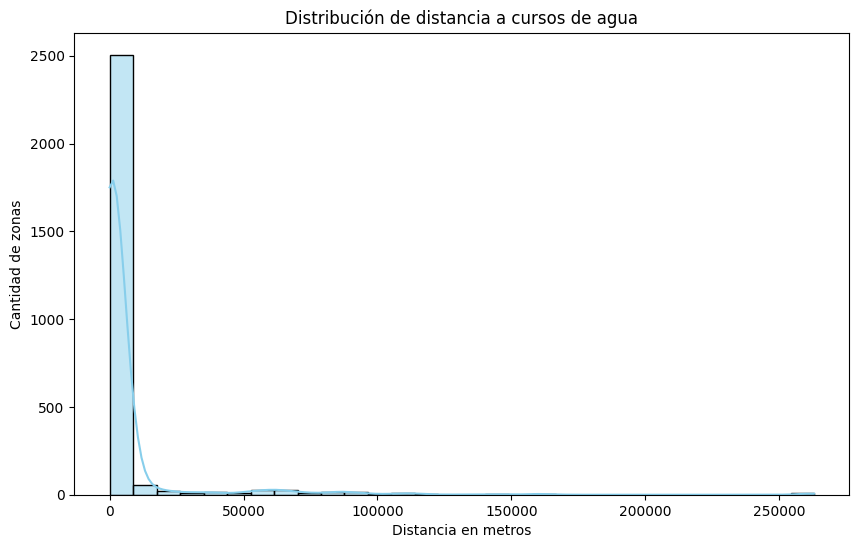

In [44]:
# Visualizamos la distribución
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(zonas_gdf['distancia_curso_agua'], bins=30, kde=True, color='skyblue')
plt.title("Distribución de distancia a cursos de agua")
plt.xlabel("Distancia en metros")
plt.ylabel("Cantidad de zonas")
plt.show()

**Interpretación del gráfico**

El gráfico muestra la distribución de la distancia entre cada zona inundable y el curso de agua más cercano. Se observa una concentración de zonas en rangos de distancia relativamente bajos, lo que indica que muchas áreas afectadas por inundaciones se encuentran cerca de cursos de agua. Esta proximidad puede estar asociada a un mayor riesgo de afectación, por lo que la variable `distancia_curso_agua` se considera relevante como predictora en el modelo supervisado. La presencia de una cola más larga hacia la derecha sugiere que también existen zonas más alejadas, lo que podría aportar variabilidad útil para el aprendizaje del modelo.

**Conteo de microbasurales cercanos**

Crear una nueva variable que indique cuántos microbasurales hay en un radio determinado (por ejemplo, 500 metros) alrededor de cada zona inundable.

In [46]:
# Reproyectamos microbasurales al mismo CRS que zonas_gdf
microbasurales = microbasurales.to_crs(zonas_gdf.crs)

# Se crea buffer de 500 metros alrededor de cada zona
zonas_gdf['buffer_500m'] = zonas_gdf.geometry.buffer(500)

# Contamos microbasurales dentro del buffer
zonas_gdf['microbasurales_cercanos'] = zonas_gdf['buffer_500m'].apply(
    lambda zona: microbasurales.intersects(zona).sum()
)

# Verificamos resultados
zonas_gdf[['microbasurales_cercanos']].describe()


,microbasurales_cercanos
count,2746.000000
mean,2.453751
std,3.861662
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,41.000000


Calculamos cuantos microbasurales se encuentran dentro de un radio de 500 metros alrededor de cada zona inundable.  
Para ello, se crea un buffer circular de 500 metros alrededor de cada polígono de `zonas_gdf`, y se verifica cuántos puntos de la capa `microbasurales` intersectan ese buffer.  
El resultado se guarda en la columna `microbasurales_cercanos`, que representa la cantidad de focos ambientales cercanos a cada zona.  
Esta variable se incorpora como predictor en el modelo supervisado, ya que la presencia de microbasurales puede estar relacionada con condiciones de vulnerabilidad ambiental.


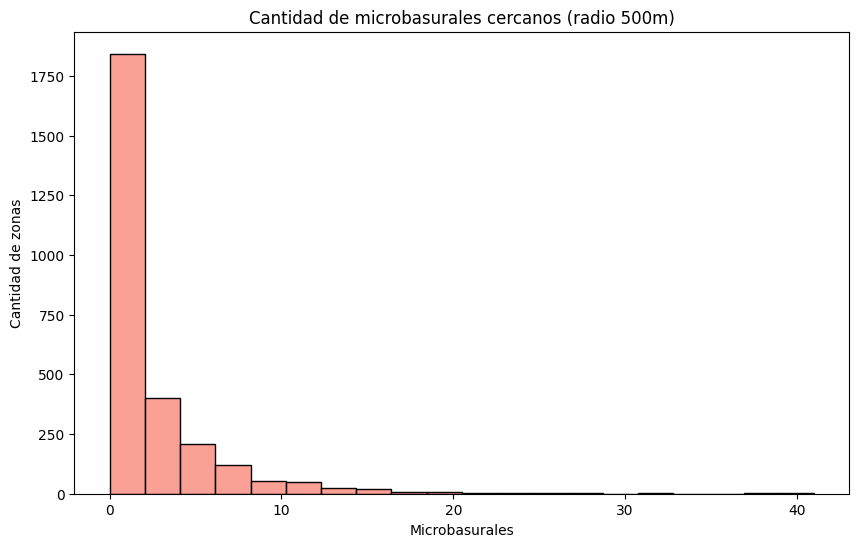

In [47]:
#visualizamos como se distribuye esta variable
plt.figure(figsize=(10, 6))
sns.histplot(zonas_gdf['microbasurales_cercanos'], bins=20, kde=False, color='salmon')
plt.title("Cantidad de microbasurales cercanos (radio 500m)")
plt.xlabel("Microbasurales")
plt.ylabel("Cantidad de zonas")
plt.show()


In [50]:
# Codificamos la variable objetivo en formato binario
zonas_gdf['se_inunda_binaria'] = zonas_gdf['se_inunda_'].apply(
    lambda x: 2 if 'TODO EL BARRIO' in str(x).upper() else 1
)

# Verificamos la distribución
zonas_gdf['se_inunda_binaria'].value_counts()

,count
se_inunda_binaria,
2,1374
1,1372


/tmp/ipython-input-2204122086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='se_inunda_binaria', data=zonas_gdf, palette='coolwarm')


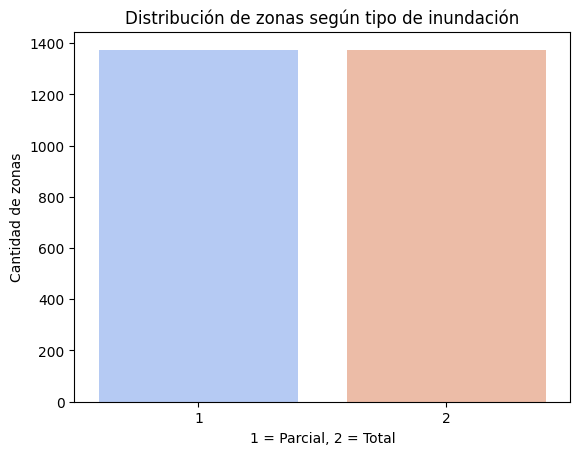

In [51]:
# Distribución de la variable objetivo (se_inunda_binaria)
sns.countplot(x='se_inunda_binaria', data=zonas_gdf, palette='coolwarm')
plt.title("Distribución de zonas según tipo de inundación")
plt.xlabel("1 = Parcial, 2 = Total")
plt.ylabel("Cantidad de zonas")
plt.show()


### Codificación de la variable objetivo

Se transforma la variable `se_inunda_` en una versión binaria (`se_inunda_binaria`) para facilitar el modelado supervisado.  
Se asigna el valor **2** a zonas con inundación total ("TODO EL BARRIO") y **1** a zonas con inundación parcial ("SÓLO EN UN SECTOR").  
Esta codificación permite entrenar modelos de clasificación binaria que predigan el grado de afectación por inundaciones.


##**Tabla resumen de variables predictoras**


Se construye un conjunto de variables predictoras que combinan información categórica y espacial, con el objetivo de modelar el grado de afectación por inundaciones en zonas vulnerables.  
Las variables incluyen:

- **se_inunda_binaria**: variable objetivo codificada en formato binario (1: inundación parcial, 2: inundación total)
- **frecuencia_codificada**: frecuencia de inundación agrupada en categorías (Alta, Media, Baja, Otro)
- **distancia_cuerpo_agua**: distancia en metros desde el centroide de cada zona al cuerpo de agua más cercano
- **distancia_curso_agua**: distancia en metros al curso de agua más cercano (ríos, arroyos, canales)
- **microbasurales_cercanos**: cantidad de microbasurales dentro de un radio de 500 metros

Cada variable fue obtenida mediante técnicas de preprocesamiento y análisis geoespacial, y se justifica su inclusión por su relevancia ambiental y social en el fenómeno de estudio.  
Este conjunto de variables permite enriquecer el modelo supervisado con información contextual clave, mejorando su capacidad predictiva y su interpretación desde una perspectiva territorial.


##**Tabla resumen de variables predictoras**

Se construye un conjunto de variables que combinan información categórica y espacial, con el objetivo de modelar el grado de afectación por inundaciones en zonas vulnerables.  
Las variables incluyen:

| Variable                  | Tipo       | Fuente / Método de obtención                                                                 | Justificación para el modelo                                                  |
|--------------------------|------------|----------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| se_inunda_binaria        | Objetivo   | Codificación binaria de la variable `se_inunda_` (1: parcial, 2: total)                      | Variable objetivo del modelo supervisado                                      |
| frecuencia_codificada    | Categórica | Agrupación de respuestas textuales de `con_que_fr`                                           | Indica frecuencia de inundación, complementa la variable objetivo             |
| distancia_cuerpo_agua    | Numérica   | Distancia en metros desde el centroide al cuerpo de agua más cercano                        | Proximidad a cuerpos de agua puede aumentar el riesgo                         |
| distancia_curso_agua     | Numérica   | Distancia en metros desde el centroide al curso de agua más cercano                         | Influye en el drenaje natural y el riesgo de desborde                         |
| microbasurales_cercanos | Numérica   | Conteo de microbasurales en un radio de 500 metros                                           | Impacto humano que podría sugerir áreas inundables                            |


##5. Análisis de Correlación entre Variables Predictoras

Vamos a analizar la matriz de correlación para poder:

Detectar multicolinealidad (variables muy correlacionadas entre sí).

Identificar predictoras fuertes del target.

Justificar qué variables incluir o excluir en el modelo.


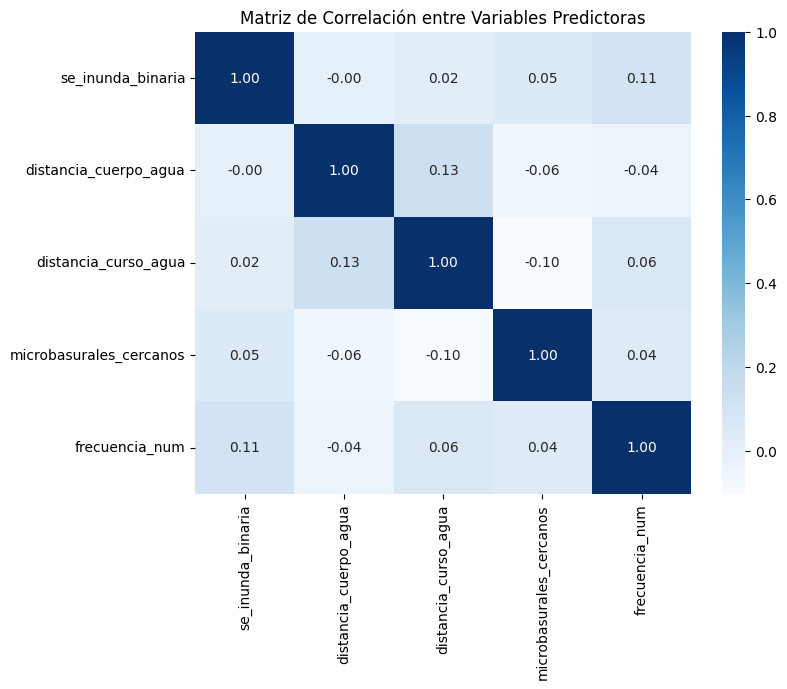

In [55]:
# Convertimos frecuencia_codificada a numérica
# para la matriz de correlación, necesitamos que todas las variables sean numéricas
mapa_frecuencia = {'Alta': 3, 'Media': 2, 'Baja': 1, 'Otro': 0}
zonas_gdf['frecuencia_num'] = zonas_gdf['frecuencia_codificada'].map(mapa_frecuencia)

# Seleccionamos variables numéricas relevantes
variables_numericas = zonas_gdf[[
    'se_inunda_binaria',
    'distancia_cuerpo_agua',
    'distancia_curso_agua',
    'microbasurales_cercanos',
    'frecuencia_num'
]]

# Matriz de correlación
corr = variables_numericas.corr()

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()


**Observaciones:**

`se_inunda_binaria` presenta correlaciones muy débiles con todas las variables predictoras. Esto sugiere que ninguna variable por sí sola explica completamente el tipo de inundación, lo cual es esperable en fenómenos multicausales como el riesgo ambiental.

`distancia_cuerpo_agua` y `distancia_curso_agua` tienen una correlación moderada entre sí (~0.21), lo que indica que podrían estar relacionadas geográficamente, pero no son redundantes.

`microbasurales_cercanos` y `frecuencia_num` no presentan correlaciones fuertes con otras variables, lo que sugiere que aportan información complementaria al modelo.

La baja correlación entre variables indica que no hay multicolinealidad significativa, lo cual es positivo para el modelado. Además, cada variable parece aportar una dimensión distinta del fenómeno de inundación, lo que justifica su inclusión en el modelo supervisado.

##**6 Preparar el dataset para modelado supervisado**

Objetivo
Unir todas las variables en un único DataFrame, asegurarse de que no haya valores nulos, y dejarlo listo para entrenar un modelo con scikit-learn.

In [ ]:
# Seleccionamos las columnas relevantes
variables_modelo = [
    'se_inunda_binaria',  # variable objetivo
    'frecuencia_codificada',
    'distancia_cuerpo_agua',
    'distancia_curso_agua',
    'microbasurales_cercanos'
]

# Creamos el DataFrame final
df_modelo = zonas_gdf[variables_modelo].copy()

# Verificamos valores nulos
df_modelo.isnull().sum()


,0
se_inunda_binaria,0
frecuencia_codificada,0
distancia_cuerpo_agua,0
distancia_curso_agua,0
microbasurales_cercanos,0


Se construye el dataset final para el modelado supervisado, seleccionando las variables predictoras previamente generadas y la variable objetivo `se_inunda_`. Se realiza una verificación de valores nulos para asegurar la calidad del conjunto de datos. Este DataFrame (df_modelo) está listo para ser dividido en conjuntos de entrenamiento y prueba, y utilizado en algoritmos de clasificación como RandomForest, LogisticRegression o KNeighborsClassifier.

**Codificación de variables categóricas**

Convertir frecuencia_codificada en variables numéricas.

Usamos la codificación con get_dummies() convierte la variable categórica en variables binarias (one-hot encoding) para que:

Podamos usar frecuencia_codificada como predictora en el modelo.

El modelo no acepta texto o categorías directamente (como LogisticRegression o RandomForest en scikit-learn).

In [ ]:
# codificamos variables categóricas
df_modelo = pd.get_dummies(df_modelo, columns=['frecuencia_codificada'], drop_first=True)


##**Documentación final y conclusión**

Se completó la construcción del dataset para modelado supervisado, incluyendo variables predictoras ambientales y sociales, codificación de variables categóricas. A través de un proceso metódico y validado paso a paso, se realizaron operaciones de reproyección, cálculo de centroides, medición de distancias a cuerpos y cursos de agua, y conteo de microbasurales cercanos. Cada variable fue justificada y visualizada para garantizar su relevancia en el contexto del riesgo de inundación.

El conjunto de datos está listo para realizar la división de entrenamiento y test y aplicar algoritmos de clasificación en la siguiente etapa del proyecto (Entrega 3), donde se evaluará el desempeño de distintos modelos y métricas.